In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import warnings
import torch.nn as nn
warnings.filterwarnings('ignore')

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-10):
        x = data[i:(i+seq_length)]
        y = data[(i+seq_length):(i+seq_length+10)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [23]:
data = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv',encoding='utf-8').groupby('소분류').sum()
data = data.drop(columns=['ID'], axis=0)

data.shape

(53, 459)

In [24]:
data.head(5)

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
소분류,,,,,,,,,,,,,,,,,,,,,
B002-C003-0001,7139,6480,6410,7237,10756,14396,16040,11582,10227,7887,...,382,393,357,7895,7158,7115,6222,5615,7389,8965
B002-C003-0002,6913,6116,6167,6303,7987,9195,9575,8381,8153,6876,...,361,340,369,4346,4218,3680,3040,4092,4345,5041
B002-C003-0003,34461,29017,27853,28234,31706,32975,31948,33171,39966,38009,...,1416,1533,1559,8360,8461,6358,6818,7024,8476,10177
B002-C003-0004,32405,29057,14608,10708,13604,15282,24105,47133,48157,46467,...,75,72,72,21656,14721,17266,18858,12717,19076,27735
B002-C003-0005,2196,2035,1195,1102,1477,1935,2199,1990,2217,1774,...,45,41,39,1124,2180,1330,923,1230,947,1972


In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.T).T
data.shape

(53, 459)

In [17]:
combined_X = []
combined_y = []

for group_data in data:
  sales_data = group_data.flatten()
  X, y = create_sequences(sales_data, 30) #length = 30
  combined_X.append(X)
  combined_y.append(y)

np.array(combined_X).shape

(53, 419, 30)

In [18]:
combined_X = np.concatenate(combined_X, axis=0)
combined_y = np.concatenate(combined_y, axis=0)

In [34]:
print(combined_X.shape)
combined_X

(22207, 30)


array([[0.20925818, 0.18908245, 0.18693935, ..., 0.23595506, 0.19018461,
        0.14239353],
       [0.18908245, 0.18693935, 0.21225852, ..., 0.19018461, 0.14239353,
        0.12521814],
       [0.18693935, 0.21225852, 0.3199951 , ..., 0.14239353, 0.12521814,
        0.11940116],
       ...,
       [0.31540873, 0.31999035, 0.01278032, ..., 0.01302146, 0.03255365,
        0.03448276],
       [0.31999035, 0.01278032, 0.01085122, ..., 0.03255365, 0.03448276,
        0.02797203],
       [0.01278032, 0.01085122, 0.00289366, ..., 0.03448276, 0.02797203,
        0.01760309]])

In [35]:
print(combined_y.shape)
combined_y

(22207, 10)


array([[0.12521814, 0.11940116, 0.11857453, ..., 0.39380951, 0.3857882 ,
        0.34240578],
       [0.11940116, 0.11857453, 0.14352631, ..., 0.3857882 , 0.34240578,
        0.38220617],
       [0.11857453, 0.14352631, 0.2709794 , ..., 0.34240578, 0.38220617,
        0.39028871],
       ...,
       [0.02797203, 0.01760309, 0.01133349, ..., 0.24451411, 0.29298288,
        0.24017362],
       [0.01760309, 0.01133349, 0.        , ..., 0.29298288, 0.24017362,
        0.17554859],
       [0.01133349, 0.        , 0.00120569, ..., 0.24017362, 0.17554859,
        0.27827345]])

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

data = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv',encoding='utf-8').groupby('소분류').sum()
data = data.drop(columns=['ID'], axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.T).T

combined_X = []
combined_y = []

for group_data in data:
  sales_data = group_data.flatten()
  X, y = create_sequences(sales_data, 30) #length = 30
  combined_X.append(X)
  combined_y.append(y)

combined_X = np.concatenate(combined_X, axis=0)
combined_y = np.concatenate(combined_y, axis=0)

# 스케일링된 데이터로 데이터셋 재구성
train_size = int(0.8 * len(combined_X))
X_train, X_test = combined_X[:train_size], combined_X[train_size:]
y_train, y_test = combined_y[:train_size], combined_y[train_size:]

# PyTorch 데이터셋 및 데이터 로더
train_dataset = TimeSeriesDataset(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# 모델 초기화
input_size = 30  # 시퀀스의 특징 수 (여기서는 판매량 하나만 사용)
hidden_layer_size = 32  # LSTM 숨겨진 레이어 크기
output_size = 1  # 출력 크기 (다음 날의 판매량 예측)

model = nn.LSTM(30, 10,batch_first=True)

# 손실 함수와 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
epochs = 100  # 에포크 수

for epoch in range(epochs):
    model.train()
    train_losses = []

    for seq, labels in tqdm(train_loader):

        y_pred,_ = model(seq)
        loss = criterion(y_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_losses = []
        for seq, labels in test_loader:
            y_pred, _ = model(seq)
            val_loss = criterion(y_pred, labels)
            val_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')



100%|██████████| 556/556 [00:01<00:00, 289.87it/s]


Epoch 1/100, Train Loss: 0.0324, Validation Loss: 0.0212


100%|██████████| 556/556 [00:01<00:00, 365.24it/s]


Epoch 2/100, Train Loss: 0.0190, Validation Loss: 0.0186


100%|██████████| 556/556 [00:01<00:00, 475.70it/s]


Epoch 3/100, Train Loss: 0.0170, Validation Loss: 0.0174


100%|██████████| 556/556 [00:01<00:00, 502.82it/s]


Epoch 4/100, Train Loss: 0.0159, Validation Loss: 0.0166


100%|██████████| 556/556 [00:01<00:00, 509.94it/s]


Epoch 5/100, Train Loss: 0.0152, Validation Loss: 0.0162


100%|██████████| 556/556 [00:01<00:00, 484.76it/s]


Epoch 6/100, Train Loss: 0.0147, Validation Loss: 0.0158


100%|██████████| 556/556 [00:01<00:00, 483.10it/s]


Epoch 7/100, Train Loss: 0.0143, Validation Loss: 0.0155


100%|██████████| 556/556 [00:01<00:00, 522.41it/s]


Epoch 8/100, Train Loss: 0.0141, Validation Loss: 0.0154


100%|██████████| 556/556 [00:01<00:00, 511.88it/s]


Epoch 9/100, Train Loss: 0.0139, Validation Loss: 0.0152


100%|██████████| 556/556 [00:01<00:00, 486.16it/s]


Epoch 10/100, Train Loss: 0.0137, Validation Loss: 0.0151


100%|██████████| 556/556 [00:01<00:00, 331.20it/s]


Epoch 11/100, Train Loss: 0.0136, Validation Loss: 0.0150


100%|██████████| 556/556 [00:02<00:00, 230.80it/s]


Epoch 12/100, Train Loss: 0.0135, Validation Loss: 0.0149


100%|██████████| 556/556 [00:01<00:00, 458.77it/s]


Epoch 13/100, Train Loss: 0.0134, Validation Loss: 0.0148


100%|██████████| 556/556 [00:01<00:00, 506.67it/s]


Epoch 14/100, Train Loss: 0.0133, Validation Loss: 0.0147


100%|██████████| 556/556 [00:01<00:00, 505.63it/s]


Epoch 15/100, Train Loss: 0.0133, Validation Loss: 0.0147


100%|██████████| 556/556 [00:01<00:00, 484.31it/s]


Epoch 16/100, Train Loss: 0.0132, Validation Loss: 0.0146


100%|██████████| 556/556 [00:01<00:00, 481.78it/s]


Epoch 17/100, Train Loss: 0.0132, Validation Loss: 0.0145


100%|██████████| 556/556 [00:01<00:00, 473.12it/s]


Epoch 18/100, Train Loss: 0.0131, Validation Loss: 0.0145


100%|██████████| 556/556 [00:01<00:00, 507.37it/s]


Epoch 19/100, Train Loss: 0.0131, Validation Loss: 0.0145


100%|██████████| 556/556 [00:01<00:00, 517.37it/s]


Epoch 20/100, Train Loss: 0.0130, Validation Loss: 0.0144


100%|██████████| 556/556 [00:01<00:00, 370.13it/s]


Epoch 21/100, Train Loss: 0.0130, Validation Loss: 0.0144


100%|██████████| 556/556 [00:01<00:00, 357.95it/s]


Epoch 22/100, Train Loss: 0.0130, Validation Loss: 0.0144


100%|██████████| 556/556 [00:01<00:00, 358.38it/s]


Epoch 23/100, Train Loss: 0.0130, Validation Loss: 0.0143


100%|██████████| 556/556 [00:01<00:00, 477.41it/s]


Epoch 24/100, Train Loss: 0.0129, Validation Loss: 0.0143


100%|██████████| 556/556 [00:01<00:00, 509.51it/s]


Epoch 25/100, Train Loss: 0.0129, Validation Loss: 0.0143


100%|██████████| 556/556 [00:01<00:00, 487.41it/s]


Epoch 26/100, Train Loss: 0.0129, Validation Loss: 0.0143


100%|██████████| 556/556 [00:01<00:00, 492.92it/s]


Epoch 27/100, Train Loss: 0.0129, Validation Loss: 0.0143


100%|██████████| 556/556 [00:01<00:00, 497.43it/s]


Epoch 28/100, Train Loss: 0.0129, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 514.18it/s]


Epoch 29/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 504.94it/s]


Epoch 30/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 441.30it/s]


Epoch 31/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 350.12it/s]


Epoch 32/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 322.92it/s]


Epoch 33/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 400.59it/s]


Epoch 34/100, Train Loss: 0.0128, Validation Loss: 0.0142


100%|██████████| 556/556 [00:01<00:00, 445.13it/s]


Epoch 35/100, Train Loss: 0.0128, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 390.39it/s]


Epoch 36/100, Train Loss: 0.0128, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 408.60it/s]


Epoch 37/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 443.57it/s]


Epoch 38/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 478.92it/s]


Epoch 39/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 374.02it/s]


Epoch 40/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 349.28it/s]


Epoch 41/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 338.11it/s]


Epoch 42/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 367.20it/s]


Epoch 43/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 442.25it/s]


Epoch 44/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 480.30it/s]


Epoch 45/100, Train Loss: 0.0127, Validation Loss: 0.0141


100%|██████████| 556/556 [00:01<00:00, 492.50it/s]


Epoch 46/100, Train Loss: 0.0127, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 489.92it/s]


Epoch 47/100, Train Loss: 0.0127, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 478.27it/s]


Epoch 48/100, Train Loss: 0.0127, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 498.21it/s]


Epoch 49/100, Train Loss: 0.0127, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 489.90it/s]


Epoch 50/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 390.08it/s]


Epoch 51/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 329.26it/s]


Epoch 52/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 351.34it/s]


Epoch 53/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 471.66it/s]


Epoch 54/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 439.63it/s]


Epoch 55/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 506.97it/s]


Epoch 56/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 439.15it/s]


Epoch 57/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 498.17it/s]


Epoch 58/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 297.85it/s]


Epoch 59/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 341.80it/s]


Epoch 60/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:02<00:00, 258.31it/s]


Epoch 61/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 347.67it/s]


Epoch 62/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 461.17it/s]


Epoch 63/100, Train Loss: 0.0126, Validation Loss: 0.0140


100%|██████████| 556/556 [00:01<00:00, 479.41it/s]


Epoch 64/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 508.14it/s]


Epoch 65/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 516.83it/s]


Epoch 66/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 487.91it/s]


Epoch 67/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 498.61it/s]


Epoch 68/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 499.63it/s]


Epoch 69/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 491.07it/s]


Epoch 70/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 365.08it/s]


Epoch 71/100, Train Loss: 0.0126, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 316.22it/s]


Epoch 72/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 387.73it/s]


Epoch 73/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 498.14it/s]


Epoch 74/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 469.85it/s]


Epoch 75/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 482.33it/s]


Epoch 76/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 493.12it/s]


Epoch 77/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 476.38it/s]


Epoch 78/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 442.11it/s]


Epoch 79/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 498.09it/s]


Epoch 80/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 298.05it/s]


Epoch 81/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 333.77it/s]


Epoch 82/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 381.64it/s]


Epoch 83/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 470.80it/s]


Epoch 84/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 396.37it/s]


Epoch 85/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 467.57it/s]


Epoch 86/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 483.11it/s]


Epoch 87/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 438.34it/s]


Epoch 88/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 473.43it/s]


Epoch 89/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 495.10it/s]


Epoch 90/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 349.40it/s]


Epoch 91/100, Train Loss: 0.0125, Validation Loss: 0.0139


100%|██████████| 556/556 [00:01<00:00, 328.34it/s]


Epoch 92/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 393.59it/s]


Epoch 93/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 448.68it/s]


Epoch 94/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 509.98it/s]


Epoch 95/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 488.00it/s]


Epoch 96/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 495.57it/s]


Epoch 97/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 512.02it/s]


Epoch 98/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 507.37it/s]


Epoch 99/100, Train Loss: 0.0125, Validation Loss: 0.0138


100%|██████████| 556/556 [00:01<00:00, 514.33it/s]


Epoch 100/100, Train Loss: 0.0125, Validation Loss: 0.0138


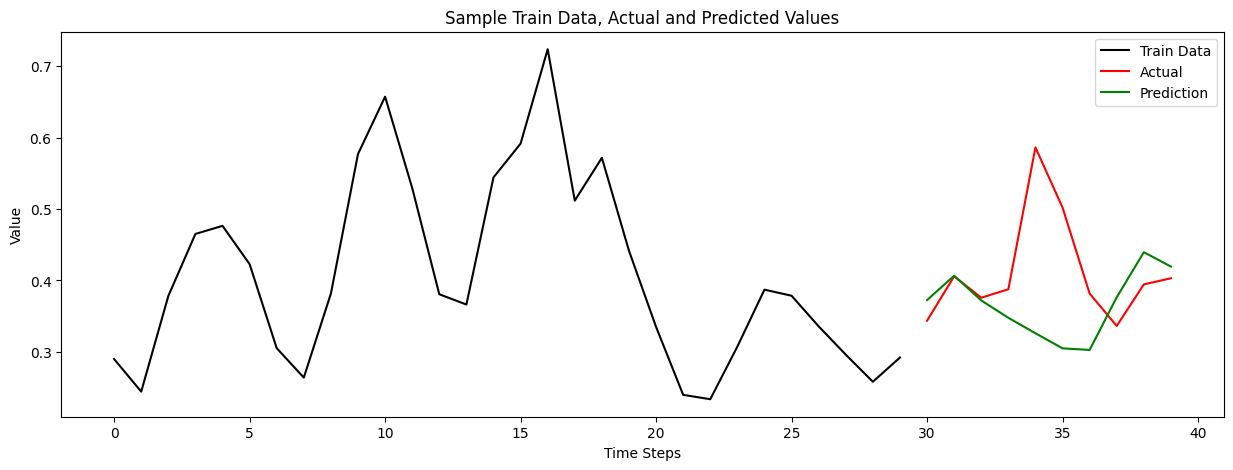

In [ ]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택 (여기서는 마지막 샘플을 사용)
sample_seq, sample_label = test_dataset[-500]

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
with torch.no_grad():
    sample_pred, _ = model(sample_seq.unsqueeze(0))  # 배치 차원 추가

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq.numpy()
sample_label = sample_label.numpy()
sample_pred = sample_pred.numpy()

# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq)), sample_seq, label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_label))
plt.plot(actual_indices, sample_label, label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
len(sample_seq) + len(sample_label)

33

In [ ]:
sample_label

array([0.50807816, 0.36243066, 0.35278514], dtype=float32)

In [ ]:
predicted_test[:, 0].shape

NameError: name 'predicted_test' is not defined